Project activities
1.	Write a function file that returns the potential energy. Apply Nelder–Mead to find the minimal energy for n = 5. Try several initial guesses until you are convinced you have the absolute minimum. How many steps are required?
2.	Plot the five atoms in the minimum energy configuration as circles, and connect all circles with line segments to view the conformed molecule.
3.	Extend the function in Step 1 so that it returns f and the gradient vector ∇ f . Apply different versions of the Gradient Descent method for the n = 5 case. Find the minimum energy as before.
4.	Apply the previous methods to n = 6. Rank the methods according to reliability and efficiency.
5.	Determine and plot minimum-energy conformations for larger n. Information on minimum-energy Lennard-Jones clusters for n up to several hundred is posted at several Internet sites, so your answers can be readily checked.



In [69]:
import numpy as np
import random
from scipy.optimize import minimize
from itertools import combinations
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

Part 1: Nelder-Mead Minimization

In [70]:
# Nelder-Mead as provided by Dr. Gidea, with minor changes.
# Will optimize N 3D points with p1 = (0,0,0) and p2 = (0,0,z).
# Parameters: function to minimize, guess, radius, max iterations, tolerance.
# f takes (N, 3) array, guess is shaped (N-2, 3)bc it doesn't include p1, p2.
def nelder_mead(f, guess, rad, k, TOL):

    # shape (N-2, 3)
    guess = np.asarray(guess)
    # Total points:
    N = guess.shape[0] + 2
    # z2 + (x, y, z) of 3...N = total parameters
    n_params = 1 + 3 * (N-2)

    # build flat array to work with:
    z2 = np.array([random.random()])
    flat_guess = np.concatenate((z2, guess.reshape(-1)))

    # Initialize the simplex:
    x = np.zeros((n_params, n_params + 1))
    x[:, 0] = flat_guess
    x[:, 1:] = flat_guess[:, np.newaxis] + rad * np.eye(n_params)

    # Evaluate function at each vertex
    y = np.array([f(x[:, j]) for j in range(n_params + 1)])

    # Objective wrapper:
    def f_wrapped(x_vec):
        z2 = x_vec[0]
        free = x_vec[1:].reshape(N - 2, 3)
        p1 = np.array([[0.0, 0.0, 0.0]])
        p2 = np.array([[0.0, 0.0, z2]])
        points = np.vstack([p1, p2, free])
        return f(points)

    # Sort function values and associated vertices
    y = np.array([f_wrapped(x[:, j]) for j in range(n_params + 1)])
    idx = np.argsort(y)
    y = y[idx]
    x = x[:, idx]
    steps = 0

    # Nelder-Mead:
    for i in range(k):
        # check for convergence:
        if np.all(np.abs(y[0] - y[1:]) < TOL):
            break
        steps += 1

        # Calculate centroid
        xbar = np.mean(x[:, :n_params], axis=1, keepdims=True)  # centroid excluding worst point
        xh = x[:, -1].reshape(-1, 1)  # worst point
        xr = 2 * xbar - xh
        yr = f_wrapped(xr.flatten())

        if yr < y[-1]: # y[-1]?
            if yr < y[0]:  # try expansion
                xe = 3 * xbar - 2 * xh
                ye = f_wrapped(xe.flatten())
                if ye < yr:
                    x[:, -1] = xe.flatten()
                    y[-1] = ye
                else:
                    x[:, -1] = xr.flatten()
                    y[-1] = yr
            else:  # accept reflection
                x[:, -1] = xr.flatten()
                y[-1] = yr
        else:
            if yr < y[-1]:  # outside contraction
                xoc = 1.5 * xbar - 0.5 * xh
                yoc = f_wrapped(xoc.flatten())
                if yoc < yr:
                    x[:, -1] = xoc.flatten()
                    y[-1] = yoc
                else:
                    # shrink
                    for j in range(1, n_params + 1):
                        x[:, j] = 0.5 * x[:, 0] + 0.5 * x[:, j]
                        y[j] = f_wrapped(x[:, j])
            else:  # inside contraction
                xic = 0.5 * xbar + 0.5 * xh
                yic = f_wrapped(xic.flatten())
                if yic < y[-1]:
                    x[:, -1] = xic.flatten()
                    y[-1] = yic
                else:
                    # shrink
                    for j in range(1, n_params + 1):
                        x[:, j] = 0.5 * x[:, 0] + 0.5 * x[:, j]
                        y[j] = f_wrapped(x[:, j])

        # Sort the simplex
        idx = np.argsort(y)
        y = y[idx]
        x = x[:, idx]

        # Final points:
        z2_final = x[0, 0]
        free_final = x[1:, 0].reshape(N - 2, 3)
        p1_final = np.array([[0.0, 0.0, 0.0]])
        p2_final = np.array([[0.0, 0.0, z2_final]])
        points_final = np.vstack([p1_final, p2_final, free_final])
        y_final = f(points_final)

    # return points, values, minimum PE, steps
    return points_final, y, y_final, steps

In [71]:
# Application to protien folding:
# minimize sum(r**-12 - 2r**-6) for all distances r between points 1...n
# Takes parameter positions of shape (N,3)
def potential_energy(positions):
    n = positions.shape[0]
    energy = 0.0
    for i in range(n):
        for j in range(i + 1, n):
            r = np.linalg.norm(positions[i] - positions[j])
            if np.isclose(r,0):
                continue # do not divide by zero
            else: energy += 1 / r**12 - 2 / r**6
    return energy

In [72]:
# To plot:
def plot_points(x_final):
     # Plot the points
     fig = plt.figure()
     ax = fig.add_subplot(111, projection='3d')
     # Plot points:
     ax.scatter(x_final[:, 0], x_final[:, 1], x_final[:, 2], color='green')
     # Connect all pairs:
     for i, j in combinations(range(len(x_final)), 2):
         ax.plot([x_final[i, 0], x_final[j, 0]],
                 [x_final[i, 1], x_final[j, 1]],
                 [x_final[i, 2], x_final[j, 2]],
                 color='gray', linewidth=0.5)
     # Annotate:
     for i, (x, y, z) in enumerate(x_final):
         ax.text(x + 0.05, y + 0.05, z + 0.05, f"P{i+1}", fontsize=9)
     ax.set_title("Optimized Points in 3D")
     ax.set_xlabel("X")
     ax.set_ylabel("Y")
     ax.set_zlabel("Z")
     plt.show()

Final simplex vertices:
 [[ 0.          0.          0.        ]
 [ 0.          0.          1.00104516]
 [ 0.72508292 -0.46879206  0.50045785]
 [ 0.68779207  0.5284303   0.50094695]
 [-0.26629588  0.82113868  0.50040649]]
Function values at vertices:
 [-9.10384172 -9.10384134 -9.10384119 -9.10384095 -9.10384085 -9.10384082
 -9.10384079 -9.10384077 -9.10384077 -9.10384075 -9.10384073]
potential energy at minimum: -9.103841717169512
Number of steps: 1671


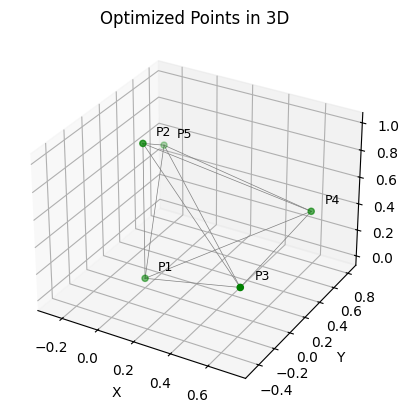

In [73]:
# Apply Nelder-Mead to minimize potential energy function for n points:
def nelder_mead_protien(n, rad = .5, k = 5000, TOL = 1e-6):

  initial_guess = np.random.rand(3, 3)  # 3 free points (p1 and p2 are fixed)
  x_final, y_vals, y_final, steps = nelder_mead(potential_energy, initial_guess, rad, k, TOL)
  print("Final simplex vertices:\n", x_final)
  print("Function values at vertices:\n", y_vals)
  print("potential energy at minimum:", y_final)
  print("Number of steps:", steps)
  plot_points(x_final)

nelder_mead_protien(5)

Part 3: Use gradient descent to minimize 5 pt distance function.

In [74]:
# Modified potential energy function to return f and df
def potential_energy_with_grad(positions):
    n     = positions.shape[0]
    energy = 0.0
    grad   = np.zeros_like(positions)

    for i in range(n):
        for j in range(i + 1, n):
            rij = positions[i] - positions[j]
            r   = np.linalg.norm(rij)
            if r == 0.0:                      # avoid /0
                continue

            inv_r   = 1.0 / r
            inv_r6  = inv_r ** 6
            inv_r12 = inv_r6 ** 2

            energy += inv_r12 - 2 * inv_r6    # Lennard‑Jones 12‑6

            dVdr    = (-12 * inv_r12 + 12 * inv_r6) * inv_r
            force   = dVdr * rij / r          # vector force
            grad[i] += force
            grad[j] -= force

    return energy, grad

In [75]:
def potential_energy(pos):           # scalar wrapper
    return potential_energy_with_grad(pos)[0]

In [76]:
# Simple gradient descent
# Input: Df=gradient, x0=initial guess, N=maximal number of steps, eps=tolerance
# Output: x=global minimum, steps=number of steps, norm of the gradient
def GD(Df, x0, eta, N, eps):
    x          = x0.copy()
    fval, grad = Df(x)
    Gradf_norm = np.linalg.norm(grad)
    steps      = 0

    print("Initial energy:", fval)
    print("Initial gradient norm:", Gradf_norm)

    while Gradf_norm > eps and steps < N:
        x          -= eta * grad
        fval, grad  = Df(x)
        Gradf_norm  = np.linalg.norm(grad)
        steps      += 1

    if Gradf_norm > eps:                      # did not converge
        steps = -1
    return x, steps, Gradf_norm



In [77]:
def GD_wrapper(x_vec, n):
    z2 = x_vec[0]
    free = x_vec[1:].reshape(n - 2, 3)
    p1 = np.array([[0.0, 0.0, 0.0]])
    p2 = np.array([[0.0, 0.0, z2]])
    all_points = np.vstack([p1, p2, free])

    energy, grad_all  = potential_energy_with_grad(all_points)

    dz2 = grad_all[1, 2]
    dfree = grad_all[2:]
    flat_grad = np.concatenate(([dz2], dfree.flatten()))
    return energy, flat_grad


Initial energy: 45.35161913489518
Initial gradient norm: 1386.9785364813197
Final simplex vertices:
 [ 1.00147347 -0.17548036  0.84515064  0.50074512 -0.39725335 -0.7663307
  0.50074512 -0.85917177  0.11823972  0.50074635]
Potential energy at minimum: -9.10385238706892
Number of steps: 5689
Norm of gradient: 0.0009934737314662983


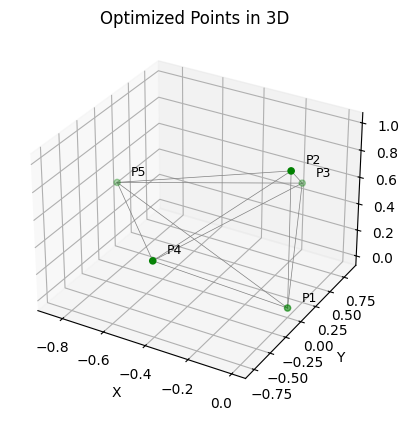

In [78]:
# Apply Gradient Descent to solve N=5 case:
def gradient_descent_protien(n, eps=1e-3, rad=0.5, k=10000, eta=1e-3):
    # Step 1: seed for reproducibility
    np.random.seed(42)
    random.seed(42)

    # Step 2: reasonable scale for initial positions (within radius)
    init_z2 = [random.uniform(0.5, 1.5)]  # ~1 unit apart
    init_free = np.random.uniform(-1, 1, size=(n-2, 3))  # small cluster
    init_guess = np.concatenate((init_z2, init_free.flatten()))

    # Step 3: define correct gradient wrapper
    Df = lambda x: GD_wrapper(x, n)

    # Step 4: Run gradient descent
    x_final, steps, norm = GD(Df, init_guess, eta, k, eps)

    # Step 5: Reconstruct 3D points
    z2_final = x_final[0]
    free_final = x_final[1:].reshape(n - 2, 3)
    p1_final = np.array([[0.0, 0.0, 0.0]])
    p2_final = np.array([[0.0, 0.0, z2_final]])
    points_final = np.vstack([p1_final, p2_final, free_final])
    energy_final, _ = potential_energy_with_grad(points_final)

    # Step 6: Output
    print("Final simplex vertices:\n", x_final)
    print("Potential energy at minimum:", energy_final)
    print("Number of steps:", steps)
    print("Norm of gradient:", norm)
    plot_points(points_final)



gradient_descent_protien(5)

In [79]:
# Backtracking function
# Input: Df=gradient, x0=initial guess,
# hyperparameters eta=intial stepsize,  factors alpha, beta,
# count = maximal number of steps
def backtrack(f, x, grad, eta, alpha, beta, max_iter=20):
    fx = f(x)
    for _ in range(max_iter):
        if f(x - eta * grad) <= fx - alpha * eta * np.dot(grad, grad):
            break
        eta *= beta
    return eta

# Gradient descent with backtracking
def GD_bt(f, Df, x0, eta, alpha, beta, max_steps, TOL):
    x          = x0.copy()
    grad       = Df(x)
    Gradf_norm = np.linalg.norm(grad)
    steps      = 0

    while Gradf_norm > TOL and steps < max_steps:
        eta_eff   = backtrack(f, x, grad, eta, alpha, beta, max_steps)
        x         -= eta_eff * grad
        grad       = Df(x)
        Gradf_norm = np.linalg.norm(grad)
        steps     += 1

    if Gradf_norm > TOL:                      # did not converge
        steps = -1
    return x, steps, Gradf_norm

Final simplex vertices:
 [0.99789969 0.86526828 0.04131313 0.4953927  0.74222526 0.58088423
 1.32577971 0.24807497 0.82997375 0.49537243]
Potential energy at minimum: -9.103852399545723
Number of steps: 86
Norm of gradient: 0.0008308395119536143


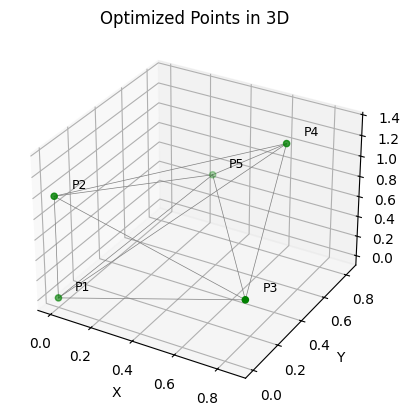

In [84]:
# Modified gradient descent that backtracks
def gradient_descent_with_backtracking_protien(n, TOL = 1e-3, rad = .5, k = 5000, eta = 1.0, alpha = 0.5, beta = 0.5):
    init_z2 = [random.random()]
    init_free = np.random.rand(n-2, 3)
    init_guess = np.concatenate((init_z2, init_free.flatten()))

    f  = lambda x: GD_wrapper(x, n)[0]
    Df = lambda x: GD_wrapper(x, n)[1]

    x_final, steps, norm = GD_bt(f, Df, init_guess, eta, alpha, beta, k, TOL)

    z2_final = x_final[0]
    free_final = x_final[1:].reshape(n - 2, 3)
    p1_final = np.array([[0.0, 0.0, 0.0]])
    p2_final = np.array([[0.0, 0.0, z2_final]])
    points_final = np.vstack([p1_final, p2_final, free_final])
    energy_final, _ = potential_energy_with_grad(points_final)

    print("Final simplex vertices:\n", x_final)
    print("Potential energy at minimum:", energy_final)
    print("Number of steps:", steps)
    print("Norm of gradient:", norm)
    plot_points(points_final)


gradient_descent_with_backtracking_protien(5)


Part 4: n = 6

Nelder-Mead:
Final simplex vertices:
 [[ 0.          0.          0.        ]
 [ 0.          0.          0.99399139]
 [ 0.54311141 -0.67959643  0.48300677]
 [ 0.29791173  0.94393036  1.02637198]
 [ 0.82234007  0.27882243  0.49627368]]
Function values at vertices:
 [-8.28843323 -8.28843316 -8.28843315 -8.28843312 -8.28843308 -8.28843303
 -8.28843303 -8.28843278 -8.28843256 -8.28843245 -8.28843232]
potential energy at minimum: -8.288433230178118
Number of steps: 951


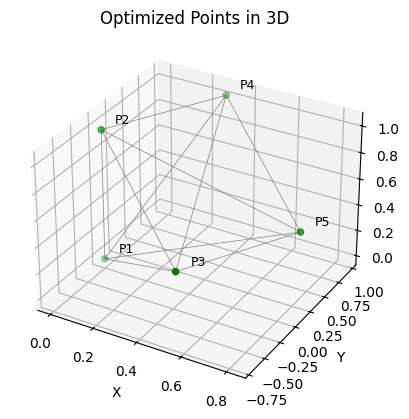

Gradient-Descent:
Initial energy: 44.07103459057907
Initial gradient norm: 1386.98091793431
Final simplex vertices:
 [ 1.00805282  0.46965962  0.72228089  0.50402165  0.07658453 -0.85429192
  0.50402204 -0.5287991   0.67531576  0.50402204  0.83674888 -0.20523437
  0.50402165]
Potential energy at minimum: -12.302927476873355
Number of steps: 5298
Norm of gradient: 0.000996777021810333


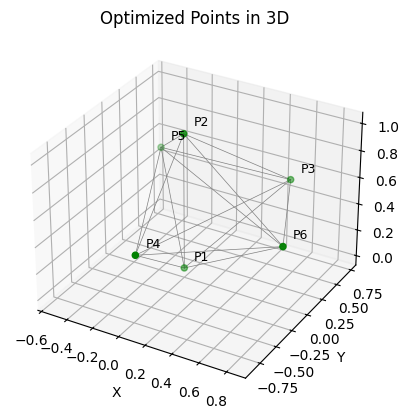

gradient-descent-with-backtracking:
Final simplex vertices:
 [ 0.99485326  0.86479239 -0.04917916  0.49884047 -0.11645952  0.91800615
  1.36011587  0.79417568  0.50747005  1.3235815   0.34008852  0.79980558
  0.4841438 ]
Potential energy at minimum: -12.302927474899635
Number of steps: 159
Norm of gradient: 0.0008474774006832102


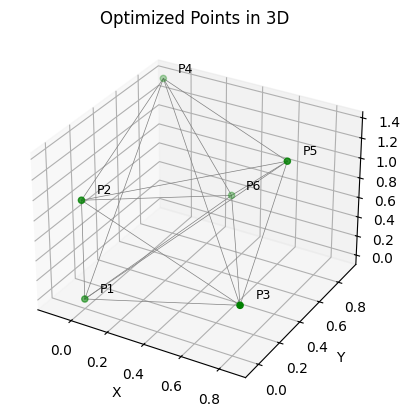

In [85]:
# Apply previous methods to n = 6 case.
# Nelder-Mead:
print("Nelder-Mead:")
nelder_mead_protien(6)
# Gradient-Descent:
print("Gradient-Descent:")
gradient_descent_protien(6)
# gradient-descent-with-backtracking:
print("gradient-descent-with-backtracking:")
gradient_descent_with_backtracking_protien(6)


Part 5: For various n

For n = 7
Nelder-Mead:
Final simplex vertices:
 [[ 0.          0.          0.        ]
 [ 0.          0.          0.99803567]
 [ 0.69668329  0.51475151  0.5024951 ]
 [ 0.71666994 -0.4865172   0.50252253]
 [ 0.94235352  0.01883702 -0.32776337]]
Function values at vertices:
 [-9.1038511  -9.10385084 -9.10385081 -9.10385062 -9.10385061 -9.10385051
 -9.10385045 -9.10385043 -9.1038503  -9.10385029 -9.1038501 ]
potential energy at minimum: -9.103851096728885
Number of steps: 1502


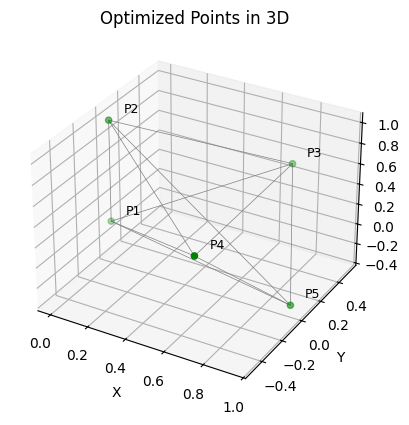

Gradient-Descent:
Initial energy: 5981.73462063458
Initial gradient norm: 211095.98139828496
Final simplex vertices:
 [   1.00147343    0.5189683     0.69485879    0.5007463  -144.08583284
  -35.44721201  -16.62952283   -0.478671      0.71829457    0.50074508
    0.82462127   -0.25509367    0.50074508  144.94634435   34.18507999
   15.30730641]
Potential energy at minimum: -9.103852387213053
Number of steps: 2632
Norm of gradient: 0.0009910015910541655


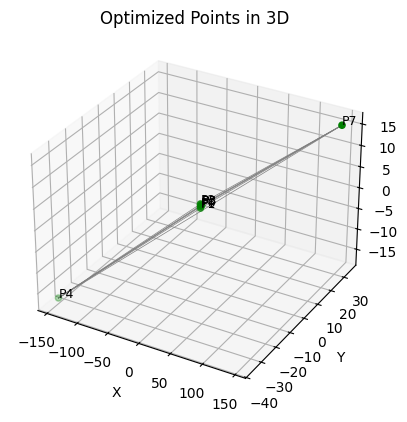

gradient-descent-with-backtracking:
Final simplex vertices:
 [ 1.00143589  0.46559158  0.83090115  1.31086579  0.78291412  0.35130887
  0.5006955  -0.10910867  0.85115671  0.50068993  0.7533343   1.34439185
  0.50065531  0.46557924  0.83085577 -0.30951037]
Potential energy at minimum: -16.50538412234266
Number of steps: 156
Norm of gradient: 0.0008687329753249026


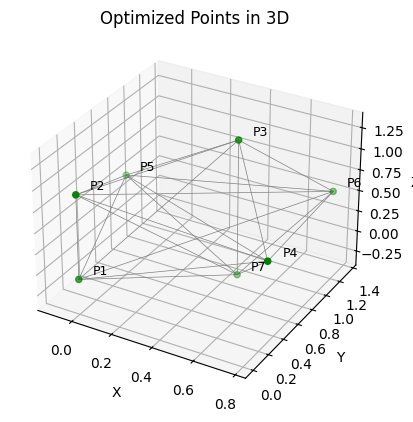

For n = 8
Nelder-Mead:
Final simplex vertices:
 [[ 0.          0.          0.        ]
 [ 0.          0.          1.0024434 ]
 [ 0.54314693  0.67494403  0.50207684]
 [ 0.83477946 -0.28139776  0.59896332]
 [ 0.8761102   0.34177864  1.38835057]]
Function values at vertices:
 [-8.93310321 -8.93310318 -8.93310311 -8.93310272 -8.93310268 -8.93310265
 -8.93310245 -8.93310244 -8.93310237 -8.93310226 -8.93310223]
potential energy at minimum: -8.93310321495112
Number of steps: 2489


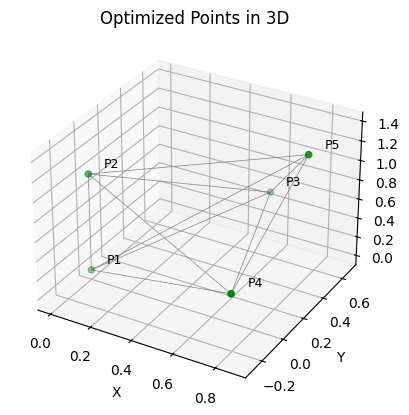

Gradient-Descent:
Initial energy: 6001.482636044272
Initial gradient norm: 211097.09702376058
Final simplex vertices:
 [   1.0080529     0.21489619    0.83036103    0.50402209 -144.08768451
  -35.44655106  -16.62787847   -0.71915113    0.47443799    0.5040217
    0.27116352   -0.81372609    0.50402209  144.94573081   34.18516687
   15.30763059   -0.68503205   -0.52249483    0.5040217 ]
Potential energy at minimum: -12.302927477161996
Number of steps: 1534
Norm of gradient: 0.000994063959163936


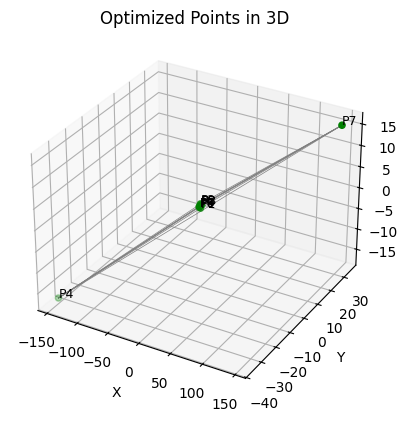

gradient-descent-with-backtracking:
Final simplex vertices:
 [ 0.999694    0.79759579  0.31791722  0.50625229 -0.06960619  0.85477285
  0.49724878  0.8149957   1.30802424  0.49861817  0.50403164  0.80909373
 -0.30993717  0.91294522 -0.09613452 -0.38720526  0.49721636  0.81334858
  1.3110168 ]
Potential energy at minimum: -19.821489121533656
Number of steps: 350
Norm of gradient: 0.0009067491332072188


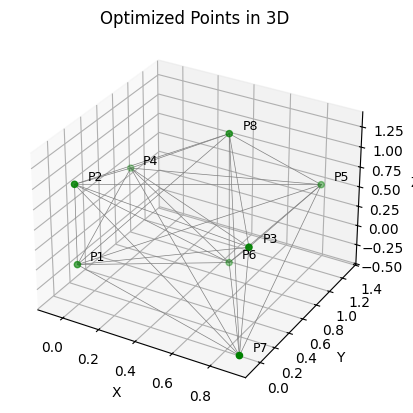

For n = 9
Nelder-Mead:
Final simplex vertices:
 [[ 0.          0.          0.        ]
 [ 0.          0.          1.00142679]
 [ 0.68944552  0.52621481  0.50068527]
 [ 0.72332049 -0.47106842  0.50063338]
 [-0.26359176  0.82189835  0.50079114]]
Function values at vertices:
 [-9.1038517  -9.1038515  -9.10385149 -9.10385136 -9.10385123 -9.10385121
 -9.10385112 -9.10385105 -9.10385081 -9.10385074 -9.10385071]
potential energy at minimum: -9.103851700747422
Number of steps: 1659


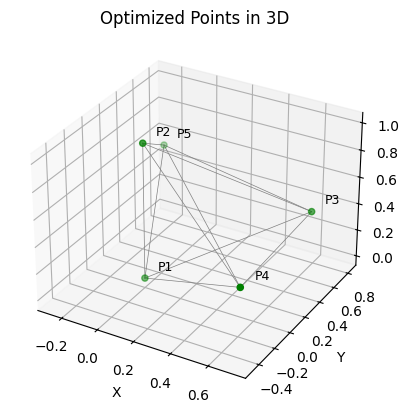

Gradient-Descent:
Initial energy: 12793.686607181391
Initial gradient norm: 249198.28093299523
Final simplex vertices:
 [   1.00147349    0.51902148    0.694819      0.50074637 -144.08785446
  -35.44641323  -16.62741377   -0.47861604    0.71833115    0.50074514
    0.82460167   -0.25515689    0.50074514  144.94415659   34.18547696
   15.30932088  -46.36679206    1.75128336  -15.81526029   12.96333397
 -101.75543897   69.14061739]
Potential energy at minimum: -9.103852387728418
Number of steps: 2634
Norm of gradient: 0.0009941839886725278


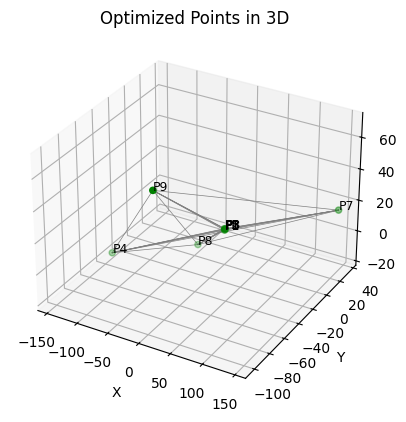

gradient-descent-with-backtracking:
Final simplex vertices:
 [ 1.00105994  0.15206488  0.84059668  0.49671232  0.49669022  1.5863917
 -0.0579981   0.69895184  0.64524141 -0.3105924   0.85727527 -0.33474053
 -0.38139845  1.12690906  1.05120228  0.49771021  0.6876869   0.66377099
  1.30954001  0.8518824   0.10218605  0.50841065]
Potential energy at minimum: -23.17075989914099
Number of steps: 383
Norm of gradient: 0.0009848452895424662


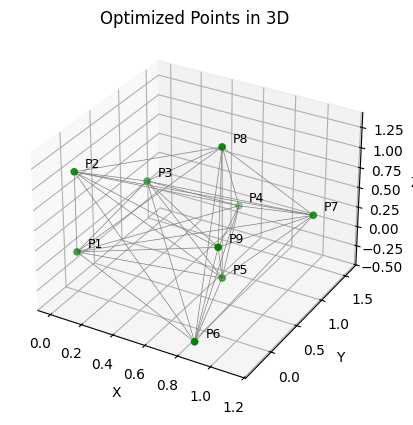

For n = 10
Nelder-Mead:
Final simplex vertices:
 [[ 0.          0.          0.        ]
 [ 0.          0.          0.99790427]
 [-0.24204857  0.83175926  0.49551786]
 [ 0.70430377  0.5044323   0.49535364]
 [ 0.3082655   0.89037868  1.32606686]]
Function values at vertices:
 [-9.10384992 -9.10384982 -9.10384974 -9.10384962 -9.10384932 -9.10384924
 -9.1038492  -9.10384911 -9.10384902 -9.10384899 -9.10384893]
potential energy at minimum: -9.103849923273563
Number of steps: 1413


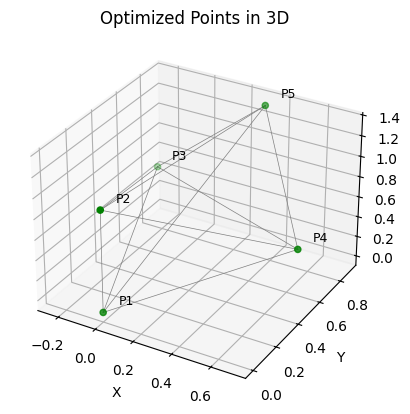

Gradient-Descent:
Initial energy: 619020.6122258276
Initial gradient norm: 31232477.39639582
Final simplex vertices:
 [ 1.00147353e+00  5.18884281e-01  6.94921439e-01  5.00746401e-01
 -1.44089676e+02 -3.54458731e+01 -1.66265790e+01 -4.78757882e-01
  7.18236599e-01  5.00745172e-01  8.24651997e-01 -2.54994129e-01
  5.00745172e-01  1.44943370e+02  3.41855675e+01  1.53095303e+01
  5.84100222e+03  1.62374968e+03  2.12211149e+04  1.32086080e+01
 -1.01756207e+02  6.93465067e+01 -5.88836399e+03 -1.62243004e+03
 -2.12374147e+04]
Potential energy at minimum: -9.103852386929766
Number of steps: 2636
Norm of gradient: 0.0009959644041579977


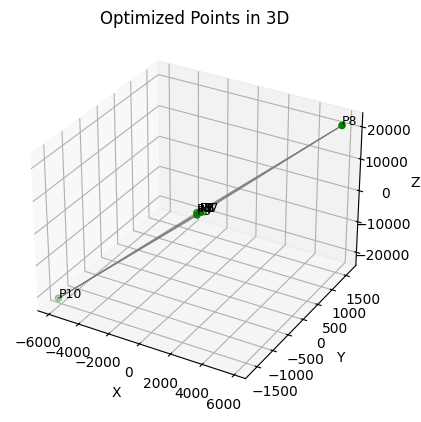

gradient-descent-with-backtracking:
Final simplex vertices:
 [ 0.98883003  0.65688813  1.40500037  0.49433286  0.42297129  0.84674465
 -0.32160209  0.92153678 -0.03790611 -0.35257369  0.4230164   0.84678643
  1.31032555  0.92157661 -0.03785739  1.34132296  0.67799062 -0.54333208
  0.4944007  -0.15450757  0.84231253  0.49438859  0.76517946  0.43057728
  0.49436768]
Potential energy at minimum: -28.422531817281204
Number of steps: 186
Norm of gradient: 0.0009203645547594643


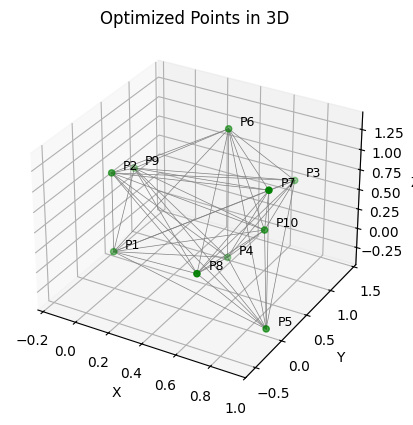

In [86]:
for n in [7, 8, 9, 10]:
  print("For n =", n)
  print("Nelder-Mead:")
  nelder_mead_protien(n)
  print("Gradient-Descent:")
  gradient_descent_protien(n)
  print("gradient-descent-with-backtracking:")
  gradient_descent_with_backtracking_protien(n)